# Breaking a CAPTCHA system with the help of CNN

A CAPTCHA --*Completely Automated Public Turing test to tell Computers and Humans Apart* -- is a type of challenge-response test used in computing to determine whether or not the user is human. For instance, CAPTCHAs are one of the most utilized solutions for preventing bots from automatically filling out forms to access websites.

In this notebook we will teach you how to defeat a captcha system using CNN.

## Dataset


The dataset we will work with was generated with the [Really Simple CAPTCHA’ plugin](https://wordpress.org/plugins/really-simple-captcha/) and consist of 10k synthetic four letter  CAPTCHA images -- “O” or “I” are avoided in the codes -- drawn from four different fonts.
 
The goal is to recognize among 32 possible letters wich ones conform the captcha image.

Populating the interactive namespace from numpy and matplotlib


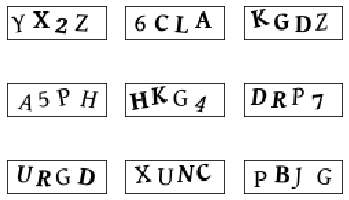

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as im
import glob
import os 

captcha_image_files = glob.glob(os.path.join('../data/generated_captcha_images', "*"))
np.random.shuffle(captcha_image_files)
test = captcha_image_files[int(len(captcha_image_files) * 0.8):]
captcha_image_files = captcha_image_files[:int(len(captcha_image_files) * 0.8)]
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    image = im.imread(captcha_image_files[i])
    plot = plt.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



## Preprocessing

In order to solve the CAPTCHA challenge we propose the following procedure:

1.   Split the image in four separate 'subimages' in a way that each one contains just a single letter

2.   Apply and train a CNN to categorize each individual letter.

#### Step 1: Extract single letters from CAPTCHA images

Concerning the first point, note that we can’t just split the images into four equal-size chunks because the CAPTCHA randomly places the letters in different horizontal locations. 

So we should delimite the boundaries or contours of the letters to separate them correctly. findContours() function of OpenCV can help us to implement a solution to this particular problem.

In [2]:
import cv2
import imutils

def get_boundary(captcha_image_file):
    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if imutils.is_cv2() else contours[1]
    return captcha_correct_text, gray, contours



Ex: Plot the contours of a captcha image using the above function

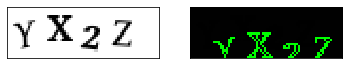

In [3]:
image_file = captcha_image_files[0]
captcha_correct_text, gray, contours = get_boundary(image_file)
ax = plt.subplot(1,2,1)
image = im.imread(image_file)
plot = plt.imshow(image)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
cv2.drawContours(image, contours, -1, (0,255,0))
plot = plt.imshow(image.astype(np.uint8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

As sometimes the CAPTCHAs have overlapping letters, we need to ensure that the extracted regions don't mash together two letters.

A simple hack here is to say that if a single contour area is a lot wider than it is tall, that means we probably have two letters squished together. In that case, we can just split the conjoined letter in half down the middle and treat it as two separate letters:

In [4]:
def split_overlapping_letters(contour):
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

    # Compare the width and height of the contour to detect letters that
    # are conjoined into one chunk
    letter_image_regions = []
    if w / h > 1.25:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))
    return letter_image_regions

Ex: Plot the bounding rectangles of a captcha image' letters using the above function

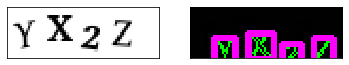

In [5]:
image_file = captcha_image_files[0]
captcha_correct_text, gray, contours = get_boundary(image_file)
letter_image_regions = []
for contour in contours:
    letter_image_regions += split_overlapping_letters(contour)


ax = plt.subplot(1,2,1)
image = im.imread(image_file)
plot = plt.imshow(image)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
image = im.imread(image_file)
cv2.drawContours(image, contours, -1, (0,255,0))
for i in range(len(letter_image_regions)):
    cv2.rectangle(image,(letter_image_regions[i][0],letter_image_regions[i][1]),
              (letter_image_regions[i][0]+letter_image_regions[i][2],
               letter_image_regions[i][1]+letter_image_regions[i][3]),(255,0,255),2)
plot = plt.imshow(image.astype(np.uint8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Ex.- Put all together and loop over the image path to get the single letters' corpus:

In [6]:
CAPTCHA_IMAGE_FOLDER = "../data/generated_captcha_images"
OUTPUT_FOLDER = "../data/extracted_letter_images"

counts = {}
# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
    captcha_correct_text, gray, contours = get_boundary(captcha_image_file)
    
    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    letter_image_regions = []
    for contour in contours:
        letter_image_regions += split_overlapping_letters(contour)

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1


[INFO] processing image 1/7964
[INFO] processing image 2/7964
[INFO] processing image 3/7964
[INFO] processing image 4/7964
[INFO] processing image 5/7964
[INFO] processing image 6/7964
[INFO] processing image 7/7964
[INFO] processing image 8/7964
[INFO] processing image 9/7964
[INFO] processing image 10/7964
[INFO] processing image 11/7964
[INFO] processing image 12/7964
[INFO] processing image 13/7964
[INFO] processing image 14/7964
[INFO] processing image 15/7964
[INFO] processing image 16/7964
[INFO] processing image 17/7964
[INFO] processing image 18/7964
[INFO] processing image 19/7964
[INFO] processing image 20/7964
[INFO] processing image 21/7964
[INFO] processing image 22/7964
[INFO] processing image 23/7964
[INFO] processing image 24/7964
[INFO] processing image 25/7964
[INFO] processing image 26/7964
[INFO] processing image 27/7964
[INFO] processing image 28/7964
[INFO] processing image 29/7964
[INFO] processing image 30/7964
[INFO] processing image 31/7964
[INFO] processing

[INFO] processing image 257/7964
[INFO] processing image 258/7964
[INFO] processing image 259/7964
[INFO] processing image 260/7964
[INFO] processing image 261/7964
[INFO] processing image 262/7964
[INFO] processing image 263/7964
[INFO] processing image 264/7964
[INFO] processing image 265/7964
[INFO] processing image 266/7964
[INFO] processing image 267/7964
[INFO] processing image 268/7964
[INFO] processing image 269/7964
[INFO] processing image 270/7964
[INFO] processing image 271/7964
[INFO] processing image 272/7964
[INFO] processing image 273/7964
[INFO] processing image 274/7964
[INFO] processing image 275/7964
[INFO] processing image 276/7964
[INFO] processing image 277/7964
[INFO] processing image 278/7964
[INFO] processing image 279/7964
[INFO] processing image 280/7964
[INFO] processing image 281/7964
[INFO] processing image 282/7964
[INFO] processing image 283/7964
[INFO] processing image 284/7964
[INFO] processing image 285/7964
[INFO] processing image 286/7964
[INFO] pro

[INFO] processing image 513/7964
[INFO] processing image 514/7964
[INFO] processing image 515/7964
[INFO] processing image 516/7964
[INFO] processing image 517/7964
[INFO] processing image 518/7964
[INFO] processing image 519/7964
[INFO] processing image 520/7964
[INFO] processing image 521/7964
[INFO] processing image 522/7964
[INFO] processing image 523/7964
[INFO] processing image 524/7964
[INFO] processing image 525/7964
[INFO] processing image 526/7964
[INFO] processing image 527/7964
[INFO] processing image 528/7964
[INFO] processing image 529/7964
[INFO] processing image 530/7964
[INFO] processing image 531/7964
[INFO] processing image 532/7964
[INFO] processing image 533/7964
[INFO] processing image 534/7964
[INFO] processing image 535/7964
[INFO] processing image 536/7964
[INFO] processing image 537/7964
[INFO] processing image 538/7964
[INFO] processing image 539/7964
[INFO] processing image 540/7964
[INFO] processing image 541/7964
[INFO] processing image 542/7964
[INFO] pro

[INFO] processing image 781/7964
[INFO] processing image 782/7964
[INFO] processing image 783/7964
[INFO] processing image 784/7964
[INFO] processing image 785/7964
[INFO] processing image 786/7964
[INFO] processing image 787/7964
[INFO] processing image 788/7964
[INFO] processing image 789/7964
[INFO] processing image 790/7964
[INFO] processing image 791/7964
[INFO] processing image 792/7964
[INFO] processing image 793/7964
[INFO] processing image 794/7964
[INFO] processing image 795/7964
[INFO] processing image 796/7964
[INFO] processing image 797/7964
[INFO] processing image 798/7964
[INFO] processing image 799/7964
[INFO] processing image 800/7964
[INFO] processing image 801/7964
[INFO] processing image 802/7964
[INFO] processing image 803/7964
[INFO] processing image 804/7964
[INFO] processing image 805/7964
[INFO] processing image 806/7964
[INFO] processing image 807/7964
[INFO] processing image 808/7964
[INFO] processing image 809/7964
[INFO] processing image 810/7964
[INFO] pro

[INFO] processing image 1053/7964
[INFO] processing image 1054/7964
[INFO] processing image 1055/7964
[INFO] processing image 1056/7964
[INFO] processing image 1057/7964
[INFO] processing image 1058/7964
[INFO] processing image 1059/7964
[INFO] processing image 1060/7964
[INFO] processing image 1061/7964
[INFO] processing image 1062/7964
[INFO] processing image 1063/7964
[INFO] processing image 1064/7964
[INFO] processing image 1065/7964
[INFO] processing image 1066/7964
[INFO] processing image 1067/7964
[INFO] processing image 1068/7964
[INFO] processing image 1069/7964
[INFO] processing image 1070/7964
[INFO] processing image 1071/7964
[INFO] processing image 1072/7964
[INFO] processing image 1073/7964
[INFO] processing image 1074/7964
[INFO] processing image 1075/7964
[INFO] processing image 1076/7964
[INFO] processing image 1077/7964
[INFO] processing image 1078/7964
[INFO] processing image 1079/7964
[INFO] processing image 1080/7964
[INFO] processing image 1081/7964
[INFO] process

[INFO] processing image 1324/7964
[INFO] processing image 1325/7964
[INFO] processing image 1326/7964
[INFO] processing image 1327/7964
[INFO] processing image 1328/7964
[INFO] processing image 1329/7964
[INFO] processing image 1330/7964
[INFO] processing image 1331/7964
[INFO] processing image 1332/7964
[INFO] processing image 1333/7964
[INFO] processing image 1334/7964
[INFO] processing image 1335/7964
[INFO] processing image 1336/7964
[INFO] processing image 1337/7964
[INFO] processing image 1338/7964
[INFO] processing image 1339/7964
[INFO] processing image 1340/7964
[INFO] processing image 1341/7964
[INFO] processing image 1342/7964
[INFO] processing image 1343/7964
[INFO] processing image 1344/7964
[INFO] processing image 1345/7964
[INFO] processing image 1346/7964
[INFO] processing image 1347/7964
[INFO] processing image 1348/7964
[INFO] processing image 1349/7964
[INFO] processing image 1350/7964
[INFO] processing image 1351/7964
[INFO] processing image 1352/7964
[INFO] process

[INFO] processing image 1594/7964
[INFO] processing image 1595/7964
[INFO] processing image 1596/7964
[INFO] processing image 1597/7964
[INFO] processing image 1598/7964
[INFO] processing image 1599/7964
[INFO] processing image 1600/7964
[INFO] processing image 1601/7964
[INFO] processing image 1602/7964
[INFO] processing image 1603/7964
[INFO] processing image 1604/7964
[INFO] processing image 1605/7964
[INFO] processing image 1606/7964
[INFO] processing image 1607/7964
[INFO] processing image 1608/7964
[INFO] processing image 1609/7964
[INFO] processing image 1610/7964
[INFO] processing image 1611/7964
[INFO] processing image 1612/7964
[INFO] processing image 1613/7964
[INFO] processing image 1614/7964
[INFO] processing image 1615/7964
[INFO] processing image 1616/7964
[INFO] processing image 1617/7964
[INFO] processing image 1618/7964
[INFO] processing image 1619/7964
[INFO] processing image 1620/7964
[INFO] processing image 1621/7964
[INFO] processing image 1622/7964
[INFO] process

[INFO] processing image 1848/7964
[INFO] processing image 1849/7964
[INFO] processing image 1850/7964
[INFO] processing image 1851/7964
[INFO] processing image 1852/7964
[INFO] processing image 1853/7964
[INFO] processing image 1854/7964
[INFO] processing image 1855/7964
[INFO] processing image 1856/7964
[INFO] processing image 1857/7964
[INFO] processing image 1858/7964
[INFO] processing image 1859/7964
[INFO] processing image 1860/7964
[INFO] processing image 1861/7964
[INFO] processing image 1862/7964
[INFO] processing image 1863/7964
[INFO] processing image 1864/7964
[INFO] processing image 1865/7964
[INFO] processing image 1866/7964
[INFO] processing image 1867/7964
[INFO] processing image 1868/7964
[INFO] processing image 1869/7964
[INFO] processing image 1870/7964
[INFO] processing image 1871/7964
[INFO] processing image 1872/7964
[INFO] processing image 1873/7964
[INFO] processing image 1874/7964
[INFO] processing image 1875/7964
[INFO] processing image 1876/7964
[INFO] process

[INFO] processing image 2110/7964
[INFO] processing image 2111/7964
[INFO] processing image 2112/7964
[INFO] processing image 2113/7964
[INFO] processing image 2114/7964
[INFO] processing image 2115/7964
[INFO] processing image 2116/7964
[INFO] processing image 2117/7964
[INFO] processing image 2118/7964
[INFO] processing image 2119/7964
[INFO] processing image 2120/7964
[INFO] processing image 2121/7964
[INFO] processing image 2122/7964
[INFO] processing image 2123/7964
[INFO] processing image 2124/7964
[INFO] processing image 2125/7964
[INFO] processing image 2126/7964
[INFO] processing image 2127/7964
[INFO] processing image 2128/7964
[INFO] processing image 2129/7964
[INFO] processing image 2130/7964
[INFO] processing image 2131/7964
[INFO] processing image 2132/7964
[INFO] processing image 2133/7964
[INFO] processing image 2134/7964
[INFO] processing image 2135/7964
[INFO] processing image 2136/7964
[INFO] processing image 2137/7964
[INFO] processing image 2138/7964
[INFO] process

[INFO] processing image 2378/7964
[INFO] processing image 2379/7964
[INFO] processing image 2380/7964
[INFO] processing image 2381/7964
[INFO] processing image 2382/7964
[INFO] processing image 2383/7964
[INFO] processing image 2384/7964
[INFO] processing image 2385/7964
[INFO] processing image 2386/7964
[INFO] processing image 2387/7964
[INFO] processing image 2388/7964
[INFO] processing image 2389/7964
[INFO] processing image 2390/7964
[INFO] processing image 2391/7964
[INFO] processing image 2392/7964
[INFO] processing image 2393/7964
[INFO] processing image 2394/7964
[INFO] processing image 2395/7964
[INFO] processing image 2396/7964
[INFO] processing image 2397/7964
[INFO] processing image 2398/7964
[INFO] processing image 2399/7964
[INFO] processing image 2400/7964
[INFO] processing image 2401/7964
[INFO] processing image 2402/7964
[INFO] processing image 2403/7964
[INFO] processing image 2404/7964
[INFO] processing image 2405/7964
[INFO] processing image 2406/7964
[INFO] process

[INFO] processing image 2636/7964
[INFO] processing image 2637/7964
[INFO] processing image 2638/7964
[INFO] processing image 2639/7964
[INFO] processing image 2640/7964
[INFO] processing image 2641/7964
[INFO] processing image 2642/7964
[INFO] processing image 2643/7964
[INFO] processing image 2644/7964
[INFO] processing image 2645/7964
[INFO] processing image 2646/7964
[INFO] processing image 2647/7964
[INFO] processing image 2648/7964
[INFO] processing image 2649/7964
[INFO] processing image 2650/7964
[INFO] processing image 2651/7964
[INFO] processing image 2652/7964
[INFO] processing image 2653/7964
[INFO] processing image 2654/7964
[INFO] processing image 2655/7964
[INFO] processing image 2656/7964
[INFO] processing image 2657/7964
[INFO] processing image 2658/7964
[INFO] processing image 2659/7964
[INFO] processing image 2660/7964
[INFO] processing image 2661/7964
[INFO] processing image 2662/7964
[INFO] processing image 2663/7964
[INFO] processing image 2664/7964
[INFO] process

[INFO] processing image 2889/7964
[INFO] processing image 2890/7964
[INFO] processing image 2891/7964
[INFO] processing image 2892/7964
[INFO] processing image 2893/7964
[INFO] processing image 2894/7964
[INFO] processing image 2895/7964
[INFO] processing image 2896/7964
[INFO] processing image 2897/7964
[INFO] processing image 2898/7964
[INFO] processing image 2899/7964
[INFO] processing image 2900/7964
[INFO] processing image 2901/7964
[INFO] processing image 2902/7964
[INFO] processing image 2903/7964
[INFO] processing image 2904/7964
[INFO] processing image 2905/7964
[INFO] processing image 2906/7964
[INFO] processing image 2907/7964
[INFO] processing image 2908/7964
[INFO] processing image 2909/7964
[INFO] processing image 2910/7964
[INFO] processing image 2911/7964
[INFO] processing image 2912/7964
[INFO] processing image 2913/7964
[INFO] processing image 2914/7964
[INFO] processing image 2915/7964
[INFO] processing image 2916/7964
[INFO] processing image 2917/7964
[INFO] process

[INFO] processing image 3147/7964
[INFO] processing image 3148/7964
[INFO] processing image 3149/7964
[INFO] processing image 3150/7964
[INFO] processing image 3151/7964
[INFO] processing image 3152/7964
[INFO] processing image 3153/7964
[INFO] processing image 3154/7964
[INFO] processing image 3155/7964
[INFO] processing image 3156/7964
[INFO] processing image 3157/7964
[INFO] processing image 3158/7964
[INFO] processing image 3159/7964
[INFO] processing image 3160/7964
[INFO] processing image 3161/7964
[INFO] processing image 3162/7964
[INFO] processing image 3163/7964
[INFO] processing image 3164/7964
[INFO] processing image 3165/7964
[INFO] processing image 3166/7964
[INFO] processing image 3167/7964
[INFO] processing image 3168/7964
[INFO] processing image 3169/7964
[INFO] processing image 3170/7964
[INFO] processing image 3171/7964
[INFO] processing image 3172/7964
[INFO] processing image 3173/7964
[INFO] processing image 3174/7964
[INFO] processing image 3175/7964
[INFO] process

[INFO] processing image 3416/7964
[INFO] processing image 3417/7964
[INFO] processing image 3418/7964
[INFO] processing image 3419/7964
[INFO] processing image 3420/7964
[INFO] processing image 3421/7964
[INFO] processing image 3422/7964
[INFO] processing image 3423/7964
[INFO] processing image 3424/7964
[INFO] processing image 3425/7964
[INFO] processing image 3426/7964
[INFO] processing image 3427/7964
[INFO] processing image 3428/7964
[INFO] processing image 3429/7964
[INFO] processing image 3430/7964
[INFO] processing image 3431/7964
[INFO] processing image 3432/7964
[INFO] processing image 3433/7964
[INFO] processing image 3434/7964
[INFO] processing image 3435/7964
[INFO] processing image 3436/7964
[INFO] processing image 3437/7964
[INFO] processing image 3438/7964
[INFO] processing image 3439/7964
[INFO] processing image 3440/7964
[INFO] processing image 3441/7964
[INFO] processing image 3442/7964
[INFO] processing image 3443/7964
[INFO] processing image 3444/7964
[INFO] process

[INFO] processing image 3669/7964
[INFO] processing image 3670/7964
[INFO] processing image 3671/7964
[INFO] processing image 3672/7964
[INFO] processing image 3673/7964
[INFO] processing image 3674/7964
[INFO] processing image 3675/7964
[INFO] processing image 3676/7964
[INFO] processing image 3677/7964
[INFO] processing image 3678/7964
[INFO] processing image 3679/7964
[INFO] processing image 3680/7964
[INFO] processing image 3681/7964
[INFO] processing image 3682/7964
[INFO] processing image 3683/7964
[INFO] processing image 3684/7964
[INFO] processing image 3685/7964
[INFO] processing image 3686/7964
[INFO] processing image 3687/7964
[INFO] processing image 3688/7964
[INFO] processing image 3689/7964
[INFO] processing image 3690/7964
[INFO] processing image 3691/7964
[INFO] processing image 3692/7964
[INFO] processing image 3693/7964
[INFO] processing image 3694/7964
[INFO] processing image 3695/7964
[INFO] processing image 3696/7964
[INFO] processing image 3697/7964
[INFO] process

[INFO] processing image 3919/7964
[INFO] processing image 3920/7964
[INFO] processing image 3921/7964
[INFO] processing image 3922/7964
[INFO] processing image 3923/7964
[INFO] processing image 3924/7964
[INFO] processing image 3925/7964
[INFO] processing image 3926/7964
[INFO] processing image 3927/7964
[INFO] processing image 3928/7964
[INFO] processing image 3929/7964
[INFO] processing image 3930/7964
[INFO] processing image 3931/7964
[INFO] processing image 3932/7964
[INFO] processing image 3933/7964
[INFO] processing image 3934/7964
[INFO] processing image 3935/7964
[INFO] processing image 3936/7964
[INFO] processing image 3937/7964
[INFO] processing image 3938/7964
[INFO] processing image 3939/7964
[INFO] processing image 3940/7964
[INFO] processing image 3941/7964
[INFO] processing image 3942/7964
[INFO] processing image 3943/7964
[INFO] processing image 3944/7964
[INFO] processing image 3945/7964
[INFO] processing image 3946/7964
[INFO] processing image 3947/7964
[INFO] process

[INFO] processing image 4169/7964
[INFO] processing image 4170/7964
[INFO] processing image 4171/7964
[INFO] processing image 4172/7964
[INFO] processing image 4173/7964
[INFO] processing image 4174/7964
[INFO] processing image 4175/7964
[INFO] processing image 4176/7964
[INFO] processing image 4177/7964
[INFO] processing image 4178/7964
[INFO] processing image 4179/7964
[INFO] processing image 4180/7964
[INFO] processing image 4181/7964
[INFO] processing image 4182/7964
[INFO] processing image 4183/7964
[INFO] processing image 4184/7964
[INFO] processing image 4185/7964
[INFO] processing image 4186/7964
[INFO] processing image 4187/7964
[INFO] processing image 4188/7964
[INFO] processing image 4189/7964
[INFO] processing image 4190/7964
[INFO] processing image 4191/7964
[INFO] processing image 4192/7964
[INFO] processing image 4193/7964
[INFO] processing image 4194/7964
[INFO] processing image 4195/7964
[INFO] processing image 4196/7964
[INFO] processing image 4197/7964
[INFO] process

[INFO] processing image 4428/7964
[INFO] processing image 4429/7964
[INFO] processing image 4430/7964
[INFO] processing image 4431/7964
[INFO] processing image 4432/7964
[INFO] processing image 4433/7964
[INFO] processing image 4434/7964
[INFO] processing image 4435/7964
[INFO] processing image 4436/7964
[INFO] processing image 4437/7964
[INFO] processing image 4438/7964
[INFO] processing image 4439/7964
[INFO] processing image 4440/7964
[INFO] processing image 4441/7964
[INFO] processing image 4442/7964
[INFO] processing image 4443/7964
[INFO] processing image 4444/7964
[INFO] processing image 4445/7964
[INFO] processing image 4446/7964
[INFO] processing image 4447/7964
[INFO] processing image 4448/7964
[INFO] processing image 4449/7964
[INFO] processing image 4450/7964
[INFO] processing image 4451/7964
[INFO] processing image 4452/7964
[INFO] processing image 4453/7964
[INFO] processing image 4454/7964
[INFO] processing image 4455/7964
[INFO] processing image 4456/7964
[INFO] process

[INFO] processing image 4683/7964
[INFO] processing image 4684/7964
[INFO] processing image 4685/7964
[INFO] processing image 4686/7964
[INFO] processing image 4687/7964
[INFO] processing image 4688/7964
[INFO] processing image 4689/7964
[INFO] processing image 4690/7964
[INFO] processing image 4691/7964
[INFO] processing image 4692/7964
[INFO] processing image 4693/7964
[INFO] processing image 4694/7964
[INFO] processing image 4695/7964
[INFO] processing image 4696/7964
[INFO] processing image 4697/7964
[INFO] processing image 4698/7964
[INFO] processing image 4699/7964
[INFO] processing image 4700/7964
[INFO] processing image 4701/7964
[INFO] processing image 4702/7964
[INFO] processing image 4703/7964
[INFO] processing image 4704/7964
[INFO] processing image 4705/7964
[INFO] processing image 4706/7964
[INFO] processing image 4707/7964
[INFO] processing image 4708/7964
[INFO] processing image 4709/7964
[INFO] processing image 4710/7964
[INFO] processing image 4711/7964
[INFO] process

[INFO] processing image 4949/7964
[INFO] processing image 4950/7964
[INFO] processing image 4951/7964
[INFO] processing image 4952/7964
[INFO] processing image 4953/7964
[INFO] processing image 4954/7964
[INFO] processing image 4955/7964
[INFO] processing image 4956/7964
[INFO] processing image 4957/7964
[INFO] processing image 4958/7964
[INFO] processing image 4959/7964
[INFO] processing image 4960/7964
[INFO] processing image 4961/7964
[INFO] processing image 4962/7964
[INFO] processing image 4963/7964
[INFO] processing image 4964/7964
[INFO] processing image 4965/7964
[INFO] processing image 4966/7964
[INFO] processing image 4967/7964
[INFO] processing image 4968/7964
[INFO] processing image 4969/7964
[INFO] processing image 4970/7964
[INFO] processing image 4971/7964
[INFO] processing image 4972/7964
[INFO] processing image 4973/7964
[INFO] processing image 4974/7964
[INFO] processing image 4975/7964
[INFO] processing image 4976/7964
[INFO] processing image 4977/7964
[INFO] process

[INFO] processing image 5199/7964
[INFO] processing image 5200/7964
[INFO] processing image 5201/7964
[INFO] processing image 5202/7964
[INFO] processing image 5203/7964
[INFO] processing image 5204/7964
[INFO] processing image 5205/7964
[INFO] processing image 5206/7964
[INFO] processing image 5207/7964
[INFO] processing image 5208/7964
[INFO] processing image 5209/7964
[INFO] processing image 5210/7964
[INFO] processing image 5211/7964
[INFO] processing image 5212/7964
[INFO] processing image 5213/7964
[INFO] processing image 5214/7964
[INFO] processing image 5215/7964
[INFO] processing image 5216/7964
[INFO] processing image 5217/7964
[INFO] processing image 5218/7964
[INFO] processing image 5219/7964
[INFO] processing image 5220/7964
[INFO] processing image 5221/7964
[INFO] processing image 5222/7964
[INFO] processing image 5223/7964
[INFO] processing image 5224/7964
[INFO] processing image 5225/7964
[INFO] processing image 5226/7964
[INFO] processing image 5227/7964
[INFO] process

[INFO] processing image 5456/7964
[INFO] processing image 5457/7964
[INFO] processing image 5458/7964
[INFO] processing image 5459/7964
[INFO] processing image 5460/7964
[INFO] processing image 5461/7964
[INFO] processing image 5462/7964
[INFO] processing image 5463/7964
[INFO] processing image 5464/7964
[INFO] processing image 5465/7964
[INFO] processing image 5466/7964
[INFO] processing image 5467/7964
[INFO] processing image 5468/7964
[INFO] processing image 5469/7964
[INFO] processing image 5470/7964
[INFO] processing image 5471/7964
[INFO] processing image 5472/7964
[INFO] processing image 5473/7964
[INFO] processing image 5474/7964
[INFO] processing image 5475/7964
[INFO] processing image 5476/7964
[INFO] processing image 5477/7964
[INFO] processing image 5478/7964
[INFO] processing image 5479/7964
[INFO] processing image 5480/7964
[INFO] processing image 5481/7964
[INFO] processing image 5482/7964
[INFO] processing image 5483/7964
[INFO] processing image 5484/7964
[INFO] process

[INFO] processing image 5699/7964
[INFO] processing image 5700/7964
[INFO] processing image 5701/7964
[INFO] processing image 5702/7964
[INFO] processing image 5703/7964
[INFO] processing image 5704/7964
[INFO] processing image 5705/7964
[INFO] processing image 5706/7964
[INFO] processing image 5707/7964
[INFO] processing image 5708/7964
[INFO] processing image 5709/7964
[INFO] processing image 5710/7964
[INFO] processing image 5711/7964
[INFO] processing image 5712/7964
[INFO] processing image 5713/7964
[INFO] processing image 5714/7964
[INFO] processing image 5715/7964
[INFO] processing image 5716/7964
[INFO] processing image 5717/7964
[INFO] processing image 5718/7964
[INFO] processing image 5719/7964
[INFO] processing image 5720/7964
[INFO] processing image 5721/7964
[INFO] processing image 5722/7964
[INFO] processing image 5723/7964
[INFO] processing image 5724/7964
[INFO] processing image 5725/7964
[INFO] processing image 5726/7964
[INFO] processing image 5727/7964
[INFO] process

[INFO] processing image 5944/7964
[INFO] processing image 5945/7964
[INFO] processing image 5946/7964
[INFO] processing image 5947/7964
[INFO] processing image 5948/7964
[INFO] processing image 5949/7964
[INFO] processing image 5950/7964
[INFO] processing image 5951/7964
[INFO] processing image 5952/7964
[INFO] processing image 5953/7964
[INFO] processing image 5954/7964
[INFO] processing image 5955/7964
[INFO] processing image 5956/7964
[INFO] processing image 5957/7964
[INFO] processing image 5958/7964
[INFO] processing image 5959/7964
[INFO] processing image 5960/7964
[INFO] processing image 5961/7964
[INFO] processing image 5962/7964
[INFO] processing image 5963/7964
[INFO] processing image 5964/7964
[INFO] processing image 5965/7964
[INFO] processing image 5966/7964
[INFO] processing image 5967/7964
[INFO] processing image 5968/7964
[INFO] processing image 5969/7964
[INFO] processing image 5970/7964
[INFO] processing image 5971/7964
[INFO] processing image 5972/7964
[INFO] process

[INFO] processing image 6202/7964
[INFO] processing image 6203/7964
[INFO] processing image 6204/7964
[INFO] processing image 6205/7964
[INFO] processing image 6206/7964
[INFO] processing image 6207/7964
[INFO] processing image 6208/7964
[INFO] processing image 6209/7964
[INFO] processing image 6210/7964
[INFO] processing image 6211/7964
[INFO] processing image 6212/7964
[INFO] processing image 6213/7964
[INFO] processing image 6214/7964
[INFO] processing image 6215/7964
[INFO] processing image 6216/7964
[INFO] processing image 6217/7964
[INFO] processing image 6218/7964
[INFO] processing image 6219/7964
[INFO] processing image 6220/7964
[INFO] processing image 6221/7964
[INFO] processing image 6222/7964
[INFO] processing image 6223/7964
[INFO] processing image 6224/7964
[INFO] processing image 6225/7964
[INFO] processing image 6226/7964
[INFO] processing image 6227/7964
[INFO] processing image 6228/7964
[INFO] processing image 6229/7964
[INFO] processing image 6230/7964
[INFO] process

[INFO] processing image 6446/7964
[INFO] processing image 6447/7964
[INFO] processing image 6448/7964
[INFO] processing image 6449/7964
[INFO] processing image 6450/7964
[INFO] processing image 6451/7964
[INFO] processing image 6452/7964
[INFO] processing image 6453/7964
[INFO] processing image 6454/7964
[INFO] processing image 6455/7964
[INFO] processing image 6456/7964
[INFO] processing image 6457/7964
[INFO] processing image 6458/7964
[INFO] processing image 6459/7964
[INFO] processing image 6460/7964
[INFO] processing image 6461/7964
[INFO] processing image 6462/7964
[INFO] processing image 6463/7964
[INFO] processing image 6464/7964
[INFO] processing image 6465/7964
[INFO] processing image 6466/7964
[INFO] processing image 6467/7964
[INFO] processing image 6468/7964
[INFO] processing image 6469/7964
[INFO] processing image 6470/7964
[INFO] processing image 6471/7964
[INFO] processing image 6472/7964
[INFO] processing image 6473/7964
[INFO] processing image 6474/7964
[INFO] process

[INFO] processing image 6688/7964
[INFO] processing image 6689/7964
[INFO] processing image 6690/7964
[INFO] processing image 6691/7964
[INFO] processing image 6692/7964
[INFO] processing image 6693/7964
[INFO] processing image 6694/7964
[INFO] processing image 6695/7964
[INFO] processing image 6696/7964
[INFO] processing image 6697/7964
[INFO] processing image 6698/7964
[INFO] processing image 6699/7964
[INFO] processing image 6700/7964
[INFO] processing image 6701/7964
[INFO] processing image 6702/7964
[INFO] processing image 6703/7964
[INFO] processing image 6704/7964
[INFO] processing image 6705/7964
[INFO] processing image 6706/7964
[INFO] processing image 6707/7964
[INFO] processing image 6708/7964
[INFO] processing image 6709/7964
[INFO] processing image 6710/7964
[INFO] processing image 6711/7964
[INFO] processing image 6712/7964
[INFO] processing image 6713/7964
[INFO] processing image 6714/7964
[INFO] processing image 6715/7964
[INFO] processing image 6716/7964
[INFO] process

[INFO] processing image 6930/7964
[INFO] processing image 6931/7964
[INFO] processing image 6932/7964
[INFO] processing image 6933/7964
[INFO] processing image 6934/7964
[INFO] processing image 6935/7964
[INFO] processing image 6936/7964
[INFO] processing image 6937/7964
[INFO] processing image 6938/7964
[INFO] processing image 6939/7964
[INFO] processing image 6940/7964
[INFO] processing image 6941/7964
[INFO] processing image 6942/7964
[INFO] processing image 6943/7964
[INFO] processing image 6944/7964
[INFO] processing image 6945/7964
[INFO] processing image 6946/7964
[INFO] processing image 6947/7964
[INFO] processing image 6948/7964
[INFO] processing image 6949/7964
[INFO] processing image 6950/7964
[INFO] processing image 6951/7964
[INFO] processing image 6952/7964
[INFO] processing image 6953/7964
[INFO] processing image 6954/7964
[INFO] processing image 6955/7964
[INFO] processing image 6956/7964
[INFO] processing image 6957/7964
[INFO] processing image 6958/7964
[INFO] process

[INFO] processing image 7180/7964
[INFO] processing image 7181/7964
[INFO] processing image 7182/7964
[INFO] processing image 7183/7964
[INFO] processing image 7184/7964
[INFO] processing image 7185/7964
[INFO] processing image 7186/7964
[INFO] processing image 7187/7964
[INFO] processing image 7188/7964
[INFO] processing image 7189/7964
[INFO] processing image 7190/7964
[INFO] processing image 7191/7964
[INFO] processing image 7192/7964
[INFO] processing image 7193/7964
[INFO] processing image 7194/7964
[INFO] processing image 7195/7964
[INFO] processing image 7196/7964
[INFO] processing image 7197/7964
[INFO] processing image 7198/7964
[INFO] processing image 7199/7964
[INFO] processing image 7200/7964
[INFO] processing image 7201/7964
[INFO] processing image 7202/7964
[INFO] processing image 7203/7964
[INFO] processing image 7204/7964
[INFO] processing image 7205/7964
[INFO] processing image 7206/7964
[INFO] processing image 7207/7964
[INFO] processing image 7208/7964
[INFO] process

[INFO] processing image 7449/7964
[INFO] processing image 7450/7964
[INFO] processing image 7451/7964
[INFO] processing image 7452/7964
[INFO] processing image 7453/7964
[INFO] processing image 7454/7964
[INFO] processing image 7455/7964
[INFO] processing image 7456/7964
[INFO] processing image 7457/7964
[INFO] processing image 7458/7964
[INFO] processing image 7459/7964
[INFO] processing image 7460/7964
[INFO] processing image 7461/7964
[INFO] processing image 7462/7964
[INFO] processing image 7463/7964
[INFO] processing image 7464/7964
[INFO] processing image 7465/7964
[INFO] processing image 7466/7964
[INFO] processing image 7467/7964
[INFO] processing image 7468/7964
[INFO] processing image 7469/7964
[INFO] processing image 7470/7964
[INFO] processing image 7471/7964
[INFO] processing image 7472/7964
[INFO] processing image 7473/7964
[INFO] processing image 7474/7964
[INFO] processing image 7475/7964
[INFO] processing image 7476/7964
[INFO] processing image 7477/7964
[INFO] process

[INFO] processing image 7694/7964
[INFO] processing image 7695/7964
[INFO] processing image 7696/7964
[INFO] processing image 7697/7964
[INFO] processing image 7698/7964
[INFO] processing image 7699/7964
[INFO] processing image 7700/7964
[INFO] processing image 7701/7964
[INFO] processing image 7702/7964
[INFO] processing image 7703/7964
[INFO] processing image 7704/7964
[INFO] processing image 7705/7964
[INFO] processing image 7706/7964
[INFO] processing image 7707/7964
[INFO] processing image 7708/7964
[INFO] processing image 7709/7964
[INFO] processing image 7710/7964
[INFO] processing image 7711/7964
[INFO] processing image 7712/7964
[INFO] processing image 7713/7964
[INFO] processing image 7714/7964
[INFO] processing image 7715/7964
[INFO] processing image 7716/7964
[INFO] processing image 7717/7964
[INFO] processing image 7718/7964
[INFO] processing image 7719/7964
[INFO] processing image 7720/7964
[INFO] processing image 7721/7964
[INFO] processing image 7722/7964
[INFO] process

[INFO] processing image 7964/7964


#### Step 2: Train the neural network to recognize single letters

We’ll use a simple convolutional neural network architecture with two convolutional layers and two fully-connected layers:

![Alt text](../imgs/13_CNN_Network_Model.png)

Ex: Implement the above architecture using keras:

In [7]:
def cnn_net():
    # Build the neural network!
    model = Sequential()

    # First convolutional layer with max pooling
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second convolutional layer with max pooling
    model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Hidden layer with 500 nodes
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))

    # Output layer with 32 nodes (one for each possible letter/number we predict)
    model.add(Dense(32, activation="softmax"))
    return model


Train the network using 10 episodes and save the model.
Use the next auxiliar function to resize an image to a given size:

In [8]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

Train the model:

In [9]:
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

LETTER_IMAGES_FOLDER = "../data/extracted_letter_images"
MODELS_PATH = "../models/"
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)
MODEL_FILENAME = "../models/captcha_model.hdf5"
MODEL_LABELS_FILENAME = "../models/model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

# Build the neural network!
model = cnn_net()

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)

# Save the trained model to disk
model.save(MODEL_FILENAME)


Using TensorFlow backend.


Train on 23679 samples, validate on 7894 samples
Epoch 1/10
23679/23679 [==============================] - 41s 2ms/step - loss: 0.2467 - acc: 0.9389 - val_loss: 0.0283 - val_acc: 0.9939
Epoch 2/10
23679/23679 [==============================] - 40s 2ms/step - loss: 0.0136 - acc: 0.9971 - val_loss: 0.0202 - val_acc: 0.9944
Epoch 3/10
23679/23679 [==============================] - 41s 2ms/step - loss: 0.0068 - acc: 0.9982 - val_loss: 0.0148 - val_acc: 0.9956
Epoch 4/10
23679/23679 [==============================] - 43s 2ms/step - loss: 0.0034 - acc: 0.9990 - val_loss: 0.0233 - val_acc: 0.9951
Epoch 5/10
23679/23679 [==============================] - 39s 2ms/step - loss: 0.0058 - acc: 0.9984 - val_loss: 0.0114 - val_acc: 0.9967
Epoch 6/10
23679/23679 [==============================] - 39s 2ms/step - loss: 0.0043 - acc: 0.9989 - val_loss: 0.0133 - val_acc: 0.9967
Epoch 7/10
23679/23679 [==============================] - 39s 2ms/step - loss: 0.0058 - acc: 0.9983 - val_loss: 0.0395 - val_acc:

## Solve CAPTCHAs

Finally, we use our trained model to solve CAPTCHAs. The steps to make the predictions are similar to the ones describe above:

- Break up the CAPTCHA image into four separate letter images (use the same approach we used to create the training dataset)

- Ask our neural network to make a separate prediction for each letter image.

- Use the four predicted letters as the answer to the CAPTCHA.

And that's all! Let's codify the predictions and have a look at the decoding CAPTCHAs:

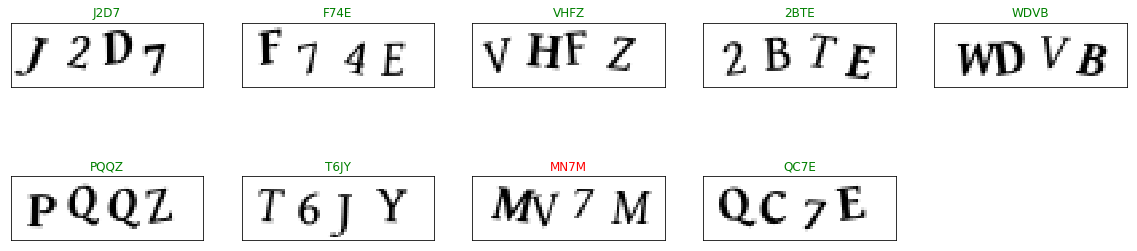

In [10]:
from keras.models import load_model

# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

figure = plt.figure(figsize=(20, 8))
# loop over the image paths
for i, image_file in enumerate(test[:9]):
    # Load the image and convert it to grayscale
    captcha_correct_text, gray, contours = get_boundary(image_file)
    letter_image_regions = []
    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        letter_image_regions += split_overlapping_letters(contour)

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

    # Print the captcha's text
    label = image_file.split('.')[2].split('/')[-1]
    captcha_text = "".join(predictions)
    
    # Plot captcha, their predicted labels and ground truth
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(im.imread(image_file))
    # Set the title for each image
    ax.set_title("{}".format(captcha_text), color=("green" if captcha_text == label else "red"))


## References

https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710